# MFPT final plotting

Gather all points generated by `langevin-ft-automated.ipynb` or `langevin-ft-automated-automated.ipynb` (using `langevin-survival.cpp`) and make nice plots against theoretical curves computed by `common.py`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import csv, os
import scipy.optimize
import scipy.special as ss
from common import *
from math import *
π = np.pi

In [2]:
def load_folder (path):
    global Res
    for i in range(999):
        itempath = path+"/"+str(i)
        ppath = itempath+"-params.csv"
        if os.path.exists(ppath):
            df = pd.read_csv(ppath, sep=',', header=None)
            df = df.set_index(0).T
            if not 'mfpt' in df.columns:
                first_times = np.array(pd.read_csv(itempath+"-ft.csv", names=['ft'])['ft'])
                df['mfpt'] = np.mean(first_times)
                df['fpt_stdev'] = np.std(first_times)
                df['n_traj'] = len(first_times)
                del first_times
                df.T.to_csv(itempath+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
            if not 'Delta_t' in df.columns:
                df['Delta_t'] = 50 * 1.5e-6
            df['i'] = i
            #if (df['Delta_t']/df['part_m']).iloc[0] < 1e-3 or df['part_m'].iloc[0] < 1e-5:
            if True:
                Res = Res.append(df, ignore_index=True, sort=False)
                
    Res['tau'] = 4*Res['D']*Res['mfpt']/Res['L']**2
    Res['tau_err'] = 4*Res['D']*(2*Res['fpt_stdev']/np.sqrt(Res['n_traj']))/Res['L']**2  # 2 sigma error bar
    
    print(len(Res))

def do_grouping (Res, by, n_colors_max=13):
    groups = Res.groupby( Res[by].apply(lambda x: round(x,2)) )
    group_pts_min = 1
    while True:
        colors = {}
        for b, Res_b in list(groups):
            if len(Res_b) > group_pts_min:
                colors[b] = None
        i = 0
        for k in colors.keys():
            colors[k] = matplotlib.colors.hsv_to_rgb((i/len(colors), 1, 1))
            i += 1
        if len(colors) <= n_colors_max:
            break
        else:
            group_pts_min += 1
    return groups, group_pts_min, colors
    
def order_c_tau (Res_b, filter_f=None):
    c = np.array(Res_b['c'])
    i = np.argsort(c)
    c = c[i]
    tau = np.array(Res_b['tau'])[i]
    err = np.array(Res_b['tau_err'])[i]
    if filter_f is not None:
        i = filter_f(c, tau)
        c = c[i]
        tau = tau[i]
        err = err[i]
    return c, tau, err

def annotate_params (Res_b, f_pos = lambda c,tau: (c,tau)):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        # $\Delta t={:.1e}$
        #plt.annotate("$\\alpha={}$, $L={:.2f}$, $m={}$, $D={}$".format(res['reset_rate'],res['L'],res['part_m'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')
        if reset_type == 'poisson':
            plt.annotate("$\\alpha={}$, $\\sigma={}$, $D={}$".format(res['reset_rate'],res['x0sigma'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')
        elif reset_type == 'per':
            plt.annotate("$T={}$, $\\sigma={}$, $D={}$".format(res['reset_period'],res['x0sigma'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')

def annotate_i (Res_b, f_pos = lambda c,tau: (c,tau)):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        plt.annotate(str(int(res['i'])), f_pos(res['c'],res['tau']), size=8, ha='center', va='center')
        
def show_labels ():
    if reset_type == 'poisson':
        plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
    elif reset_type == 'per':
        plt.xlabel(r"$c=L/\sqrt{4DT_\operatorname{res}}$")
    plt.ylabel(r"$\tau$")
    plt.legend()

# Analyse pour reset poissonnien, $b=\infty$

In [3]:
Res = pd.DataFrame()
load_folder("data-poisson-fix-m0")
load_folder("data-poisson-fix")
reset_type = 'poisson'

37
102


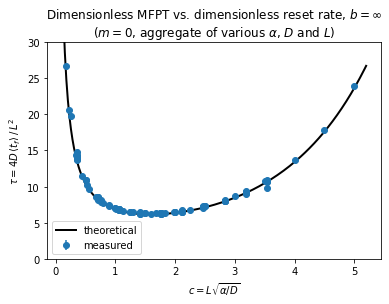

In [4]:
plt.errorbar(Res['c'], Res['tau'], yerr=Res['tau_err'], fmt='o', label="measured")
c = np.linspace(0.1,5.2,200)
plt.plot(c, fpt_poisson_tau(b=np.inf,c=c), label=r"theoretical", color='black', lw=2)
plt.ylim((0,30))
plt.legend(loc='lower left')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
#plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m/\gamma=2\cdot 10^{-4}$, aggregate of various $\alpha$, $D$ and $L$)")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m=0$, aggregate of various $\alpha$, $D$ and $L$)")
plt.savefig("langevin-mfpt-c-b_inf.pdf", bbox_inches='tight')

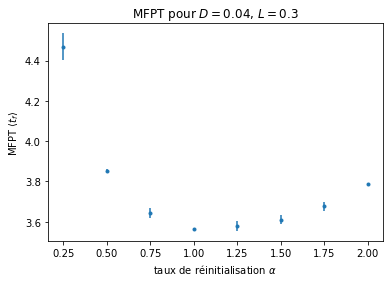

In [28]:
Res_binf_03 = Res[ (np.abs(Res['L']-0.30)<1e-10) & (np.abs(Res['D']-0.04)<1e-10) & (np.abs(Res['Delta_t']-0.000075)<1e-10) ].copy()
Res_binf_03['mfpt_err'] = Res_binf_03['fpt_stdev']/np.sqrt(Res_binf_03['n_traj'])
plt.errorbar(Res_binf_03['reset_rate'], Res_binf_03['mfpt'], yerr=Res_binf_03['mfpt_err'], fmt='.')
plt.xticks(Res_binf_03['reset_rate'])
plt.xlabel(r"taux de réinitialisation $\alpha$")
plt.ylabel(r"MFPT $\langle t_f\rangle$")
plt.title(r"MFPT pour $D=0.04$, $L=0.3$, $m/\gamma=2\cdot 10^{-4}$")
plt.savefig("langevin-mfpt-alpha-b_inf.pdf", bbox_inches='tight')

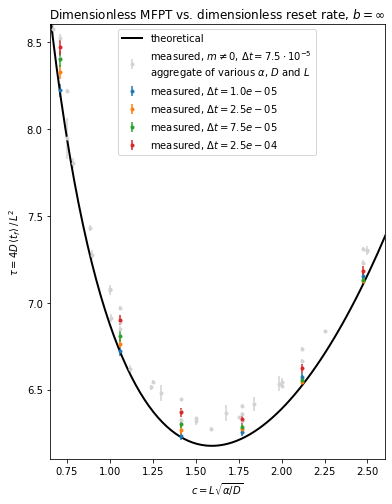

In [182]:
plt.figure(figsize=(6,8))
Res_mn0 = Res[ Res['part_m'] > 1e-3 ]
plt.errorbar(Res_mn0['c'], Res_mn0['tau'], yerr=Res_mn0['tau_err'], fmt='.', label=r"measured, $m\neq 0$, $\Delta t = 7.5\cdot 10^{-5}$"+"\n"+r"aggregate of various $\alpha$, $D$ and $L$", color='lightgray')
groups = Res[ Res['part_m'] < 1e-3 ].sort_values(by='Delta_t').groupby( Res['Delta_t'].apply(lambda x: round(x,6)) )
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau'], yerr=Res_Δt['tau_err'], fmt='.', label=r"measured, $\Delta t={:.1e}$".format(Δt))
c = np.linspace(0.1,5.2,200)
plt.plot(c, fpt_poisson_tau(b=np.inf,c=c), label=r"theoretical", color='black', lw=2)
plt.ylim((6.1,8.6))
plt.xlim((0.65,2.6))
plt.legend(loc='upper center')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$")
plt.savefig("langevin-mfpt-c-b_inf-zoom.pdf", bbox_inches='tight')

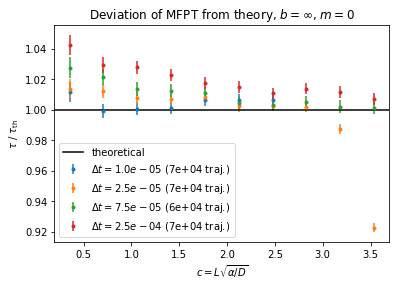

In [183]:
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau']/fpt_poisson_tau(b=np.inf,c=Res_Δt['c']),
                 yerr=Res_Δt['tau_err']/fpt_poisson_tau(np.inf,Res_Δt['c']),
                 fmt='.', label=r"$\Delta t={:.1e}$ ({:.0e} traj.)".format(Δt,Res_Δt['n_traj'].iloc[0]))
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau\ /\ \tau_\operatorname{th}$")
plt.axhline(y=1, color='black', label="theoretical")
plt.legend()
plt.title(r"Deviation of MFPT from theory, $b=\infty$, $m=0$")
plt.savefig("langevin-mfpt-c-b_inf-deviation.pdf", bbox_inches='tight')

# Analyse pour 1D, $b$ variable

In [3]:
Res = pd.DataFrame()

#load_folder("data-poisson-x0var")
#reset_type = 'poisson'

load_folder("data-periodical-x0var")
reset_type = 'per'

147


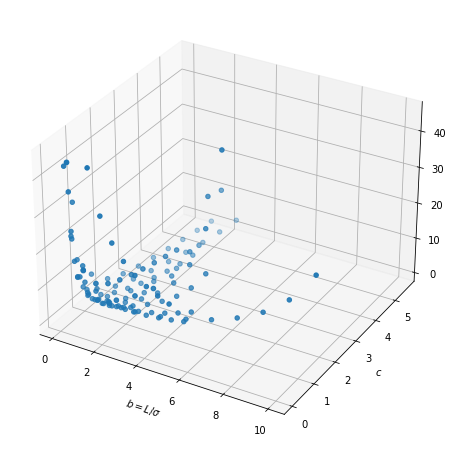

In [4]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
Res_zlim = Res[ Res['tau'] < 50 ]
ax.scatter( Res_zlim['b'], Res_zlim['c'], Res_zlim['tau'] )
#ax.scatter( Res['b'], Res['c'], th_tau(Res['b'],Res['c']) )
plt.xlabel(r"$b=L/\sigma$")
plt.ylabel(r"$c$")
plt.savefig("3d-plot-"+reset_type+".pdf", bbox_inches='tight')
plt.show()

In [5]:
if reset_type == 'none':
    th_tau = None # TODO
elif reset_type == 'poisson':
    th_tau = fpt_poisson_tau # (b, c)
elif reset_type == 'per':
    th_tau = fpt_periodic_tau # (b, c)

In [6]:
tau_th_cache = {}

In [17]:
groups, group_pts_min, colors = do_grouping(Res, by='b', n_colors_max=13)
#groups, group_pts_min, colors = do_grouping(Res[ (1 <= Res['b']) & (Res['b'] <= 3) & (Res['c'] > 0.5) ], by='b', n_colors_max=13)

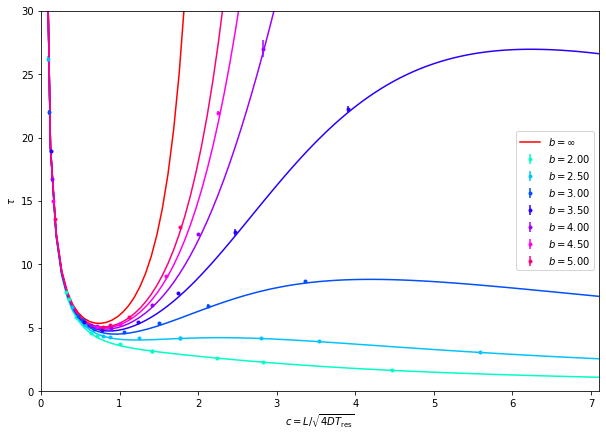

In [18]:
if reset_type == 'poisson': c_max = 12
elif reset_type == 'per': c_max = 7.1

plt.figure(figsize=(10,7))

c_th = np.linspace(0.05, c_max, 100)
plt.plot(c_th, th_tau(np.inf,c_th), color='red', label=r"$b=\infty$")

for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > group_pts_min:
        name = 'highb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c_th)
        plt.plot(c_th, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')

plt.ylim((0,30))
plt.xlim((0,c_max))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-highb.pdf", bbox_inches='tight')
plt.show()

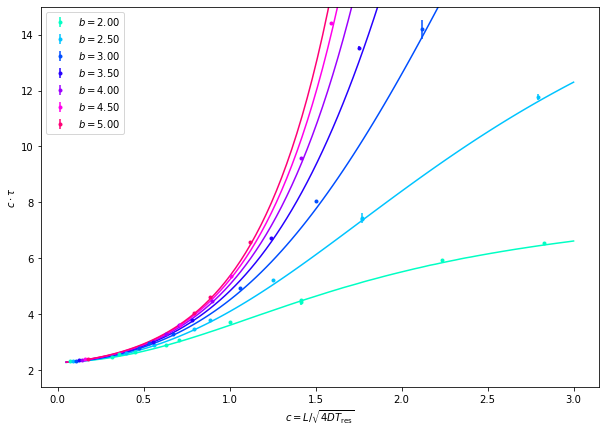

In [19]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 3, 100)
        name = 'highb-zoom'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, c*tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b, lambda c,_: c < 3)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')

plt.ylim((0.6*np.min(Res['c']*Res['tau']),15))
show_labels()
plt.ylabel(r"$c\cdot\tau$")
plt.savefig("mfpt-"+reset_type+"-x0var-highb-zoom.pdf", bbox_inches='tight')
plt.show()

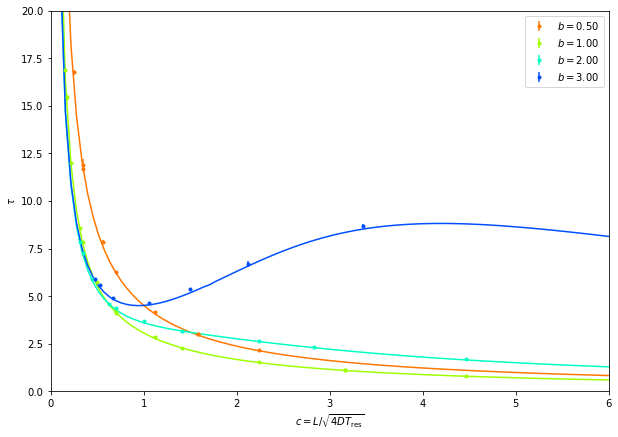

In [20]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b in [0.5,1.0,2.0,3.0]:
        c = np.linspace(0.1, 6, 100)
        name = 'commonb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        #annotate_params(Res_b)
        
plt.ylim((0,20))
plt.xlim((0,6))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-commonb.pdf", bbox_inches='tight')
plt.show()

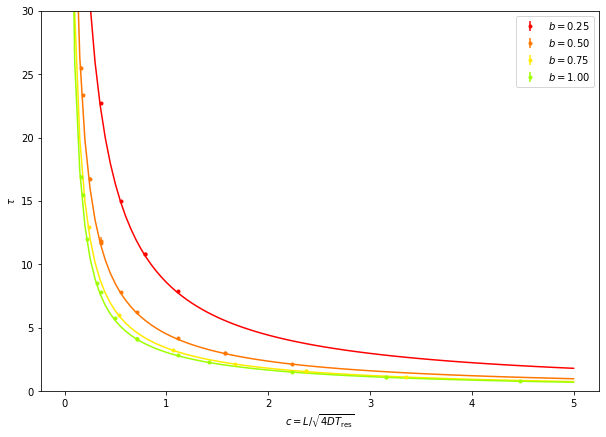

In [21]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 1.1 and b > 0.1 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 5, 100)
        name = 'lowb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')

plt.ylim((0,30))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-lowb.pdf", bbox_inches='tight')
plt.show()

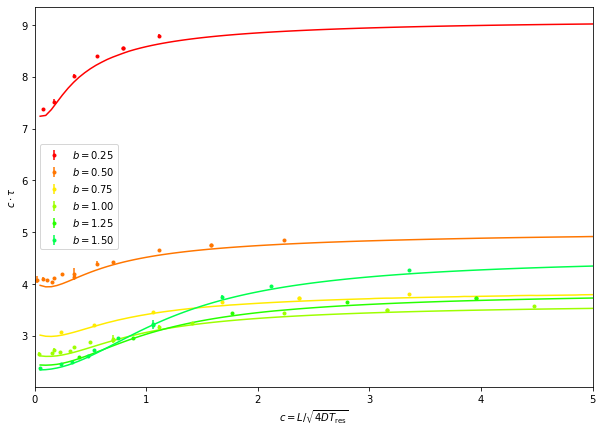

In [22]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 1.6 and b > 0.1 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 5, 100)
        name = 'lowb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, c*tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')
        #annotate_i(Res_b, lambda c,tau: (c,c*tau))

plt.xlim((0,5))
show_labels()
plt.ylabel(r"$c\cdot\tau$")
plt.savefig("mfpt-"+reset_type+"-x0var-lowb-zoom.pdf", bbox_inches='tight')
plt.show()

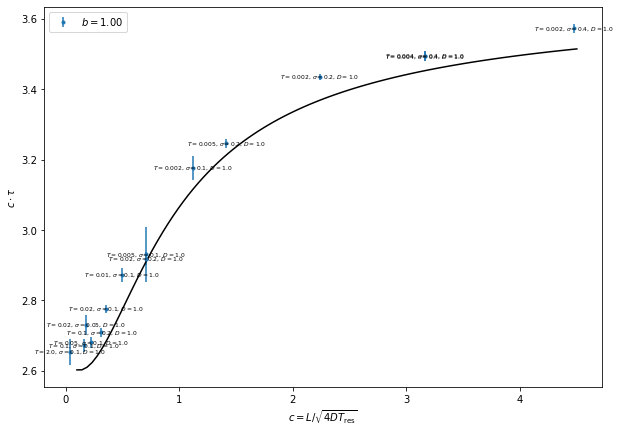

In [23]:
plt.figure(figsize=(10,7))
b = 1.0
Res_b = groups.get_group(b)
Res_b1 = Res_b[ Res_b['c'] < 5 ]
c = np.linspace(0.1, 4.5, 100)
plt.plot(c, c*th_tau(b,c), color='black')
c, tau, err = order_c_tau(Res_b1)
plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.')
annotate_params(Res_b1, lambda c,tau: (c,c*tau))

show_labels()
plt.ylabel(r"$c\cdot\tau$")
plt.savefig("mfpt-"+reset_type+"-x0var-b{}.pdf".format(b), bbox_inches='tight')
plt.show()

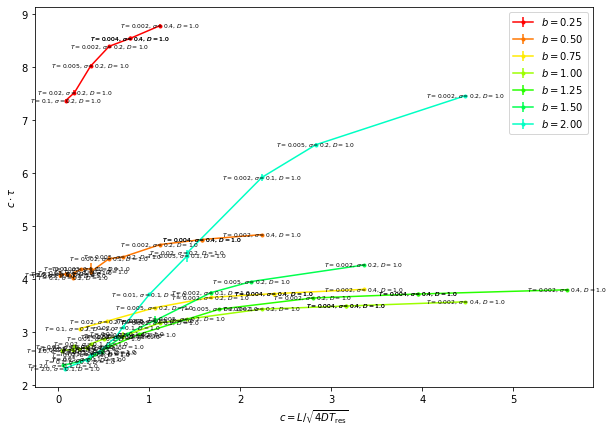

In [24]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if len(Res_b) > 3 and b <= 2 and len(Res_b) > group_pts_min:
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.-', color=colors[b])
        annotate_params(Res_b, f_pos = lambda c,tau: (c,c*tau))
        
show_labels()
plt.ylabel(r"$c\cdot\tau$")
plt.show()

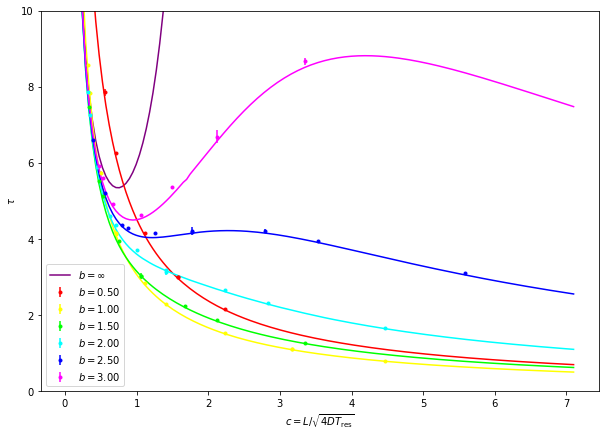

In [25]:
groups_6, group_pts_min_6, colors_6 = do_grouping(Res, by='b', n_colors_max=6)

plt.figure(figsize=(10,7))

c_th = np.linspace(0.1, c_max, 150)
plt.plot(c_th, th_tau(np.inf,c_th), color='purple', label=r"$b=\infty$")

for b, Res_b in list(groups_6):
    
    if len(Res_b) > group_pts_min_6:
        plt.plot(c_th, th_tau(b,c_th), color=colors_6[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors_6[b], yerr=err, fmt='.')
        
plt.ylim((0,10))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-all.pdf", bbox_inches='tight')
plt.show()

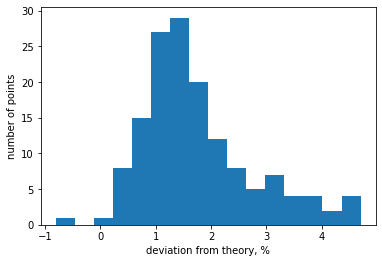

In [16]:
Res['tau_th'] = th_tau(Res['b'],Res['c'])
Res['tau_dev%'] = ((Res['tau']-Res['tau_th'])/Res['tau_th'] * 100).apply(lambda x: round(x,1))
plt.hist(Res['tau_dev%'], bins=16)
plt.xlabel(r"deviation from theory, %")
plt.ylabel("number of points")
plt.savefig("mfpt-"+reset_type+"-x0var-devhist.pdf", bbox_inches='tight')

## Experimental data
Points generated by `exp-ft-automated.ipynb`.

In [85]:
Res = pd.DataFrame()

load_folder("data-exp-2d-periodical/y-coord")
th_tau = fpt_periodic_tau # (b, c)

groups, group_pts_min, colors = do_grouping(Res, by='b', n_colors_max=20)

49


In [80]:
tau_th_cache = {}

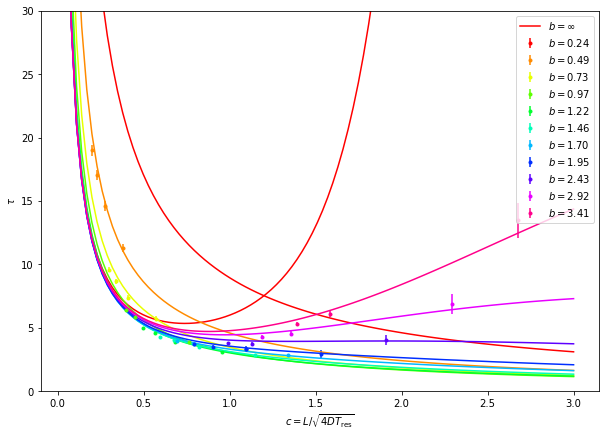

In [90]:
plt.figure(figsize=(10,7))

c_th = np.linspace(0.05, 3, 100)
plt.plot(c_th, th_tau(np.inf,c_th), color='red', label=r"$b=\infty$")

for b, Res_b in list(groups):
    if b in colors:
        name = 'all'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c_th)
        plt.plot(c_th, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')

plt.ylim((0,30))
show_labels()
plt.show()

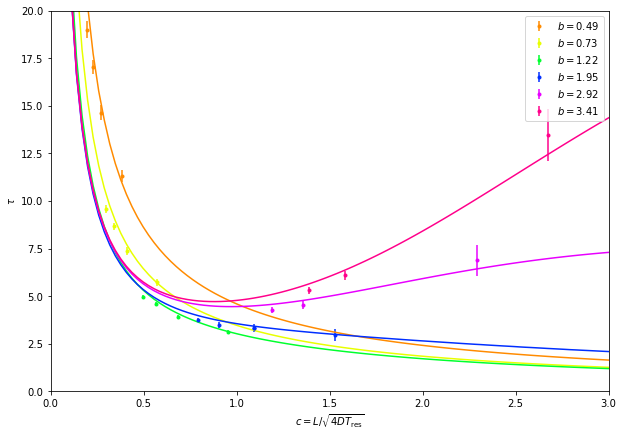

In [91]:
plt.figure(figsize=(10,7))

c_th = np.linspace(0.05, 3, 100)

for b, Res_b in list(groups):
    
    if b in [3.41, 2.92, 1.95, 0.73, 1.22, 0.49]:
        name = 'all'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c_th)
        plt.plot(c_th, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')

plt.xlim((0,3))
plt.ylim((0,20))
show_labels()
plt.savefig("mfpt-exp.pdf", bbox_inches='tight')
plt.show()

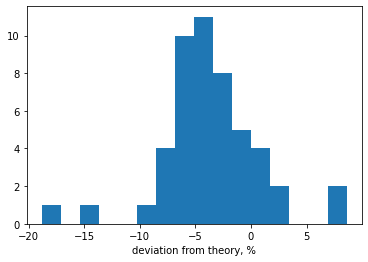

In [93]:
Res['tau_th'] = th_tau(Res['b'],Res['c'])
Res['tau_dev%'] = ((Res['tau']-Res['tau_th'])/Res['tau_th'] * 100).apply(lambda x: round(x,1))
plt.hist(Res['tau_dev%'], bins=16)
plt.xlabel(r"deviation from theory, %")
None

# Analyse pour cible 2D et reset poissonnien, $b=\infty$

In [3]:
Res = pd.DataFrame()
load_folder("data-2d-poisson-fix")
reset_type = 'poisson'

135


In [4]:
groups, group_pts_min, colors = do_grouping(Res, by='a', n_colors_max=8)

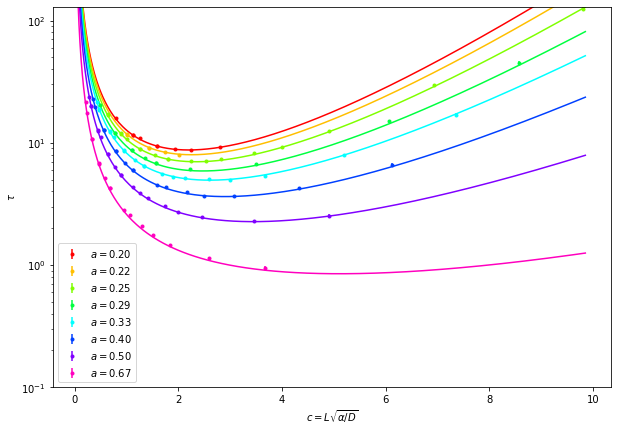

In [5]:
plt.figure(figsize=(10,7))
for a, Res_a in list(groups):
    
    if len(Res_a) > group_pts_min:
        c = np.logspace(-4, 3.3, 200, base=2)
        plt.plot(c, fpt_2d_poisson_tau(np.inf,c,a), color=colors[a])
        c, tau, err = order_c_tau(Res_a)
        plt.errorbar(c, tau, label=r"$a={:.2f}$".format(a), color=colors[a], yerr=err, fmt='.')

plt.ylim((0.1,130))
plt.yscale('log')
show_labels()
plt.savefig("mfpt-2d-poisson-b_inf.pdf", bbox_inches='tight')

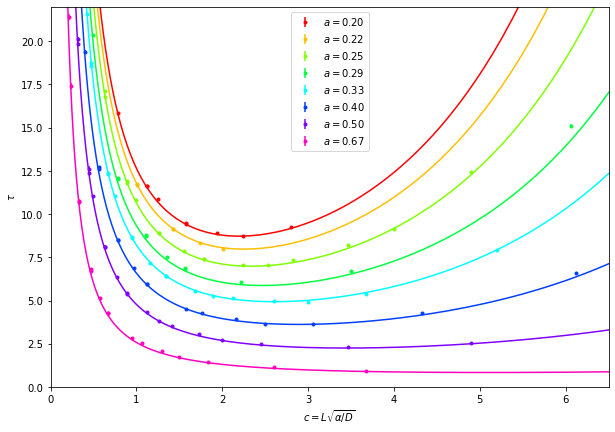

In [187]:
plt.figure(figsize=(10,7))
for a, Res_a in list(groups):
    
    if len(Res_a) > group_pts_min:
        c = np.logspace(-3, 3, 200, base=2)
        plt.plot(c, fpt_2d_poisson_tau(np.inf,c,a), color=colors[a])
        c, tau, err = order_c_tau(Res_a)
        plt.errorbar(c, tau, label=r"$a={:.2f}$".format(a), color=colors[a], yerr=err, fmt='.')

plt.ylim((0,22))
plt.xlim((0,6.5))
show_labels()
plt.savefig("mfpt-2d-poisson-b_inf-zoom.pdf", bbox_inches='tight')

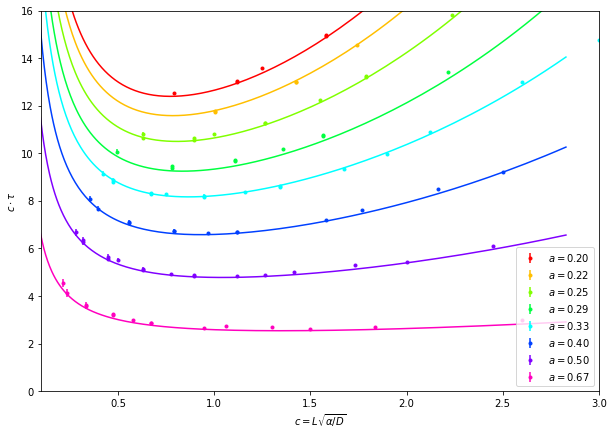

In [188]:
plt.figure(figsize=(10,7))
for a, Res_a in list(groups):
    
    if len(Res_a) > group_pts_min:
        c = np.logspace(-4, 1.5, 200, base=2)
        plt.plot(c, c*fpt_2d_poisson_tau(np.inf,c,a), color=colors[a])
        c, tau, err = order_c_tau(Res_a)
        plt.errorbar(c, c*tau, label=r"$a={:.2f}$".format(a), color=colors[a], yerr=err, fmt='.')

plt.ylim((0,16))
plt.xlim((0.1,3))
show_labels()
plt.ylabel(r"$c\cdot\tau$")
plt.savefig("mfpt-2d-poisson-b_inf-zoom-ctau.pdf", bbox_inches='tight')

# Analyse pour cible 2D et reset poissonien, $b$ variable

In [48]:
Res = pd.DataFrame()
load_folder("data-2d-poisson-x0var-ter")
Res['a'] = Res['a'].apply(lambda x: round(x,2))
Res['b'] = Res['b'].apply(lambda x: round(x,4))
Res['c'] = Res['c'].apply(lambda x: round(x,4))

140


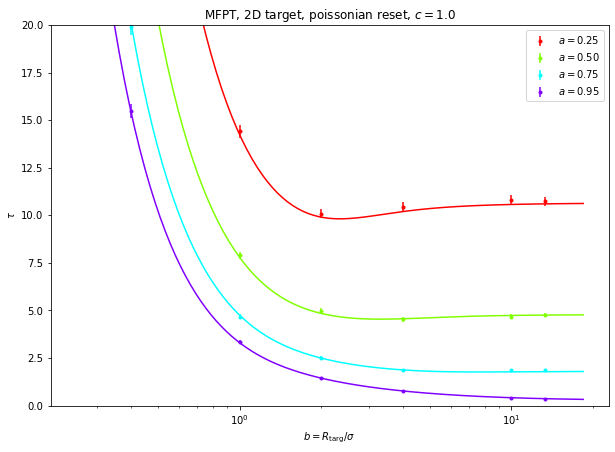

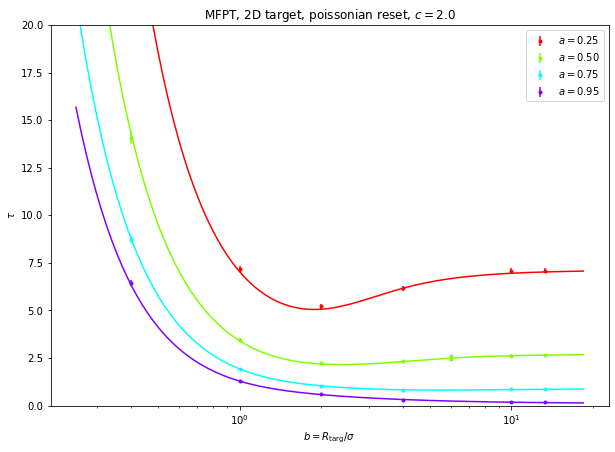

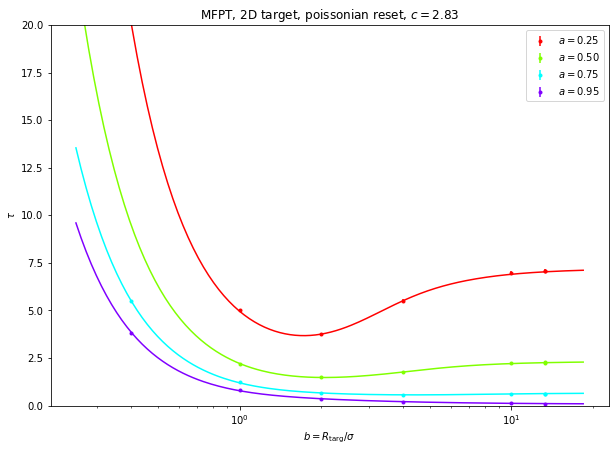

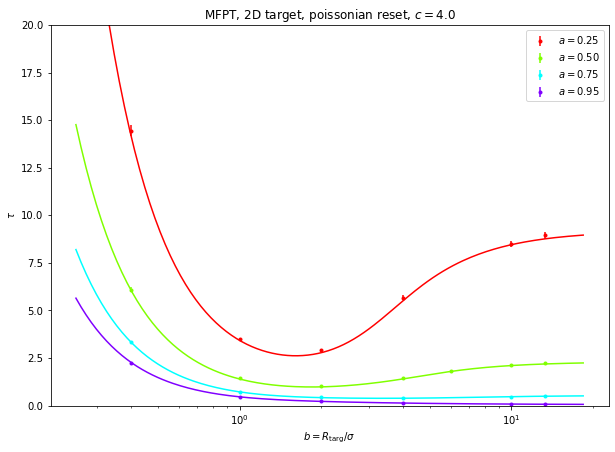

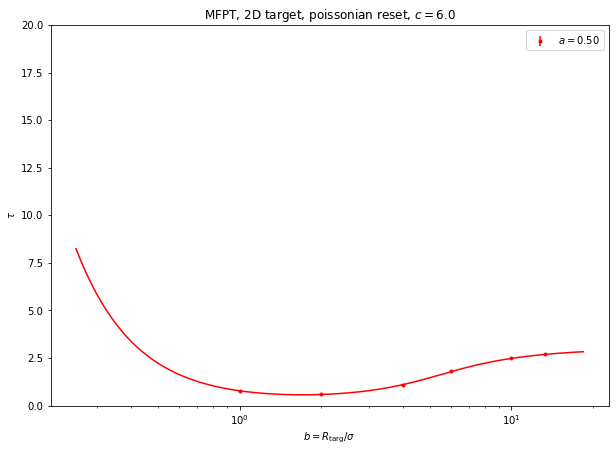

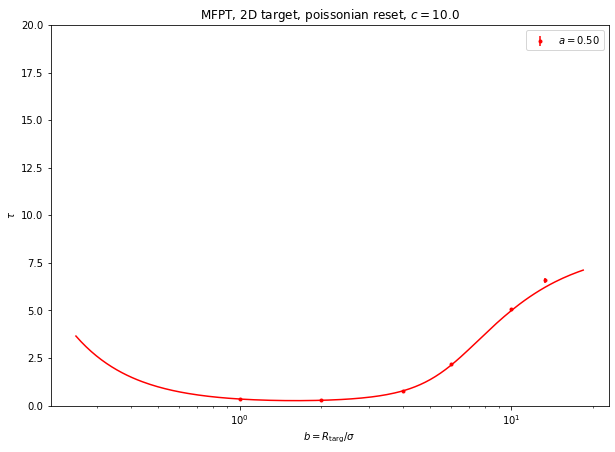

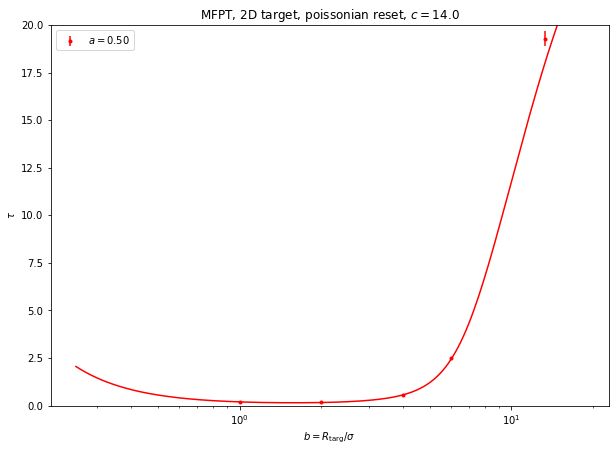

In [49]:
groups_c = Res.groupby( Res['c'].apply(lambda x: round(x,2)) )
for c, Res_c in list(groups_c):

    if len(Res_c) < 4:
        continue
    groups, group_pts_min, colors = do_grouping(Res_c, by='a', n_colors_max=8)
    
    plt.figure(figsize=(10,7))
    for a, Res_a in list(groups):

        if len(Res_a) > group_pts_min:
            b = np.logspace(-2, 4.2, 200, base=2)
            plt.plot(b, fpt_2d_poisson_tau(b,c,a), color=colors[a])
            plt.errorbar(Res_a['b'], Res_a['tau'], label=r"$a={:.2f}$".format(a), color=colors[a], yerr=Res_a['tau_err'], fmt='.')

    plt.ylim((0,20))
    plt.xscale('log')
    plt.xlabel(r"$b=R_\operatorname{targ}/\sigma$")
    plt.ylabel(r"$\tau$")
    plt.legend()
    plt.title(r"MFPT, 2D target, poissonian reset, $c={}$".format(c))
    plt.savefig("mfpt-2d-poisson-c_{}.pdf".format(c), bbox_inches='tight')
    
    #Res_binf = Res_c[ np.isinf(Res_c['b']) ]
    #plt.errorbar(Res_binf['a'], Res_binf['tau'], yerr=Res_binf['tau_err'], fmt='.')
    #a = np.linspace(0.05, 1, 100)
    #plt.plot(a, fpt_2d_poisson_tau(np.inf,c,a,do_warn_err=True))

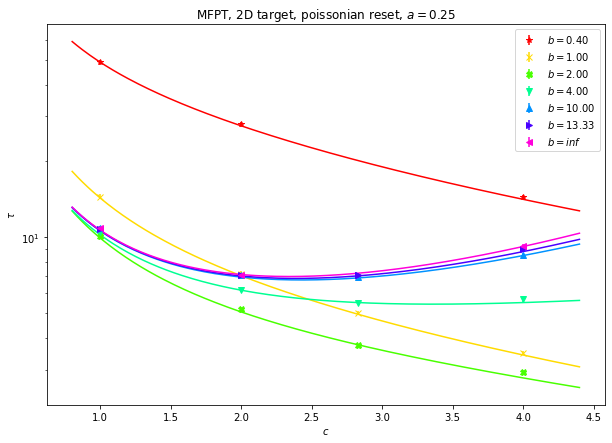

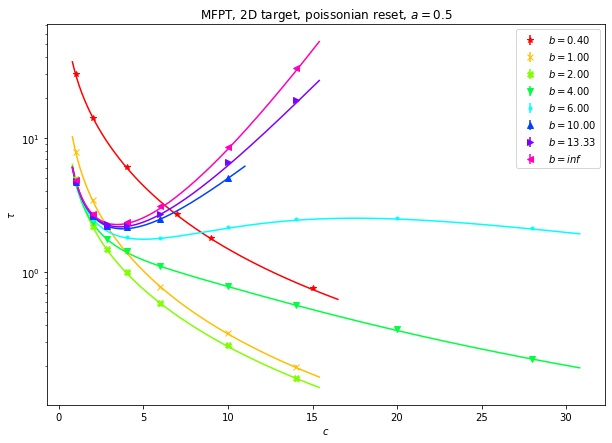

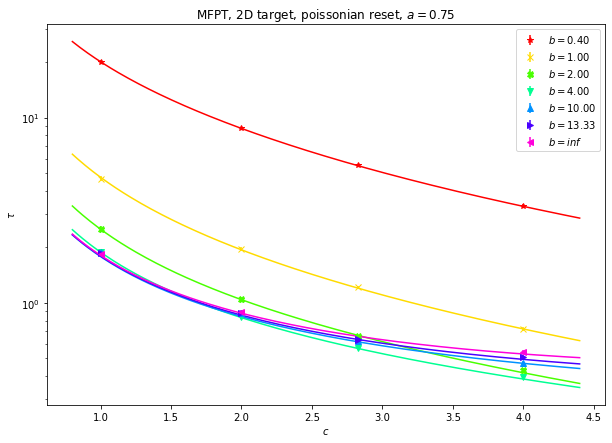

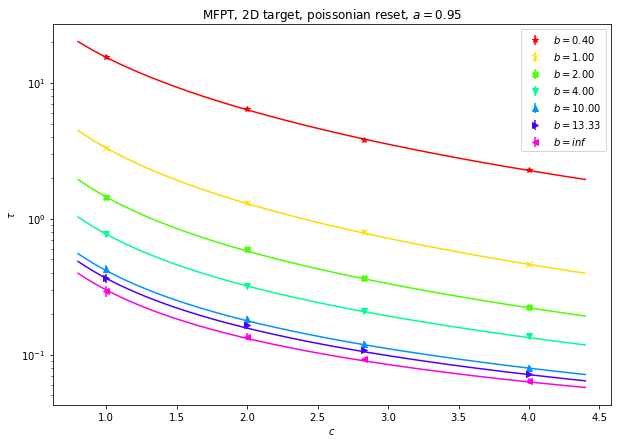

In [55]:
symbols = { 0.4: "*",
            1.0: "x",
            2.0: "X",
            4.0: "v",
            6.0: '.',
            10.0: "^",
            13.33: ">",
            np.inf: "<" }
groups_a = Res.groupby( Res['a'].apply(lambda x: round(x,2)) )
for a, Res_a in list(groups_a):

    if len(Res_a) < 5:
        continue
    groups, group_pts_min, colors = do_grouping(Res_a, by='b', n_colors_max=11)
    
    plt.figure(figsize=(10,7))
    for b, Res_b in list(groups):

        if len(Res_b) > group_pts_min: #and b in symbols.keys():
            c = np.linspace(0.8, 1.1*np.max(Res_b['c']), 200)
            plt.plot(c, fpt_2d_poisson_tau(b,c,a,), color=colors[b])
            plt.errorbar(Res_b['c'], Res_b['tau'], label=r"$b={:.2f}$".format(b), color=colors[b], yerr=Res_b['tau_err'], fmt=symbols[b])

    plt.yscale('log')
    plt.xlabel(r"$c$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.title(r"MFPT, 2D target, poissonian reset, $a={}$".format(a))
    plt.savefig("mfpt-2d-poisson-a_{}.pdf".format(a), bbox_inches='tight')

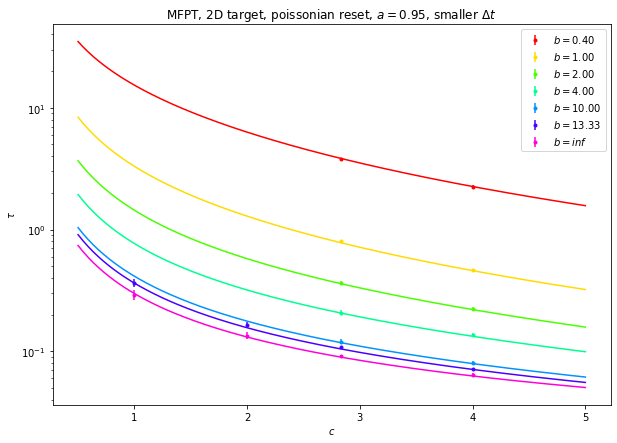

In [51]:
a = 0.95
Res_a = Res[ Res['Delta_t'] < 5e-7 ]
Res_a = Res_a[ Res_a['a'] == a ]
groups, group_pts_min, _ = do_grouping(Res_a, by='b', n_colors_max=10)
    
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):

    if len(Res_b) > group_pts_min:
        c = np.linspace(0.5, 5, 200)
        plt.plot(c, fpt_2d_poisson_tau(b,c,a), color=colors[b])
        plt.errorbar(Res_b['c'], Res_b['tau'], label=r"$b={:.2f}$".format(b), color=colors[b], yerr=Res_b['tau_err'], fmt='.')

plt.yscale('log')
plt.xlabel(r"$c$")
plt.ylabel(r"$\tau$")
plt.legend(loc='upper right')
plt.title(r"MFPT, 2D target, poissonian reset, $a={}$, smaller $\Delta t$".format(a))
plt.savefig("mfpt-2d-poisson-a_{}-smalldt.pdf".format(a), bbox_inches='tight')

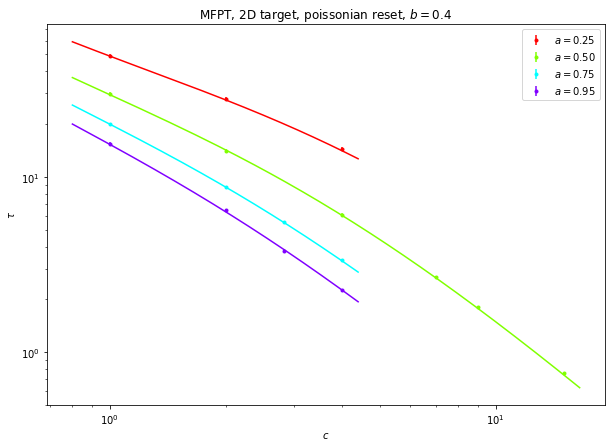

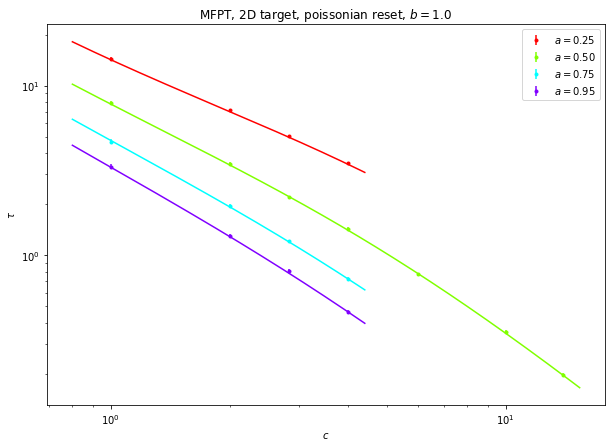

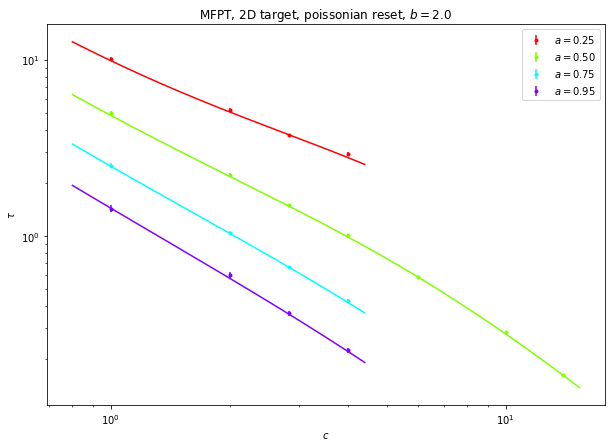

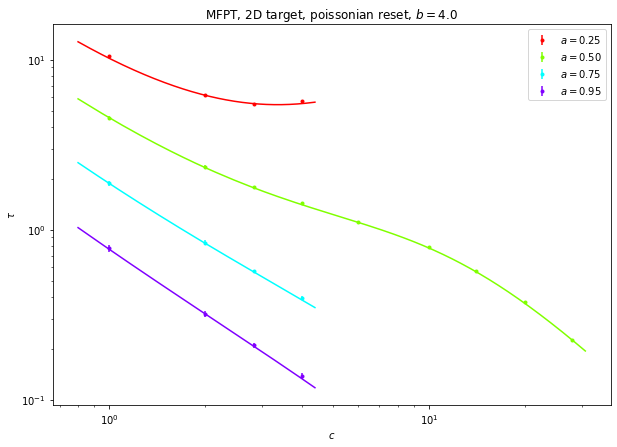

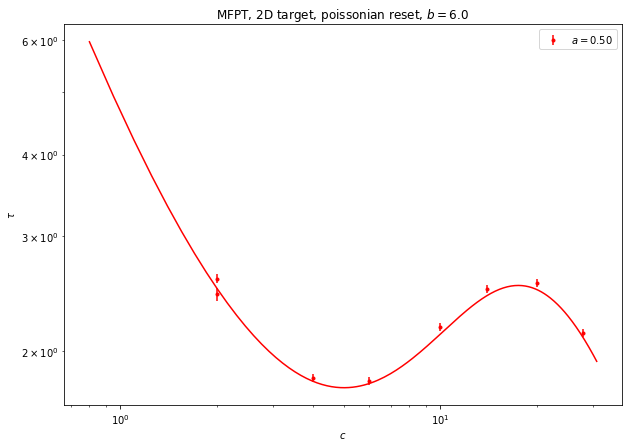

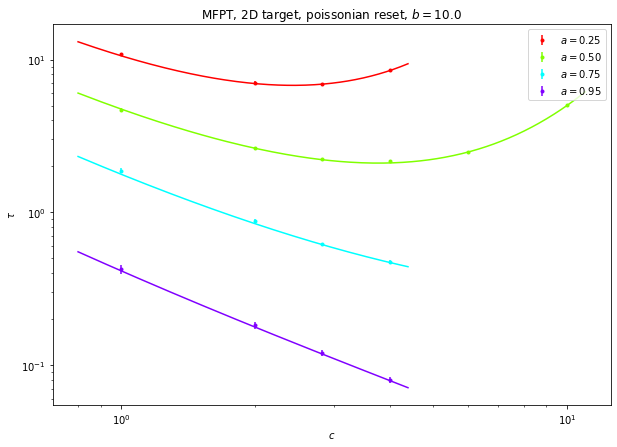

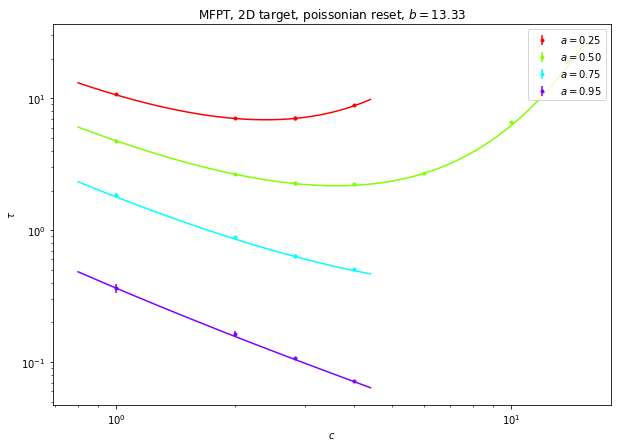

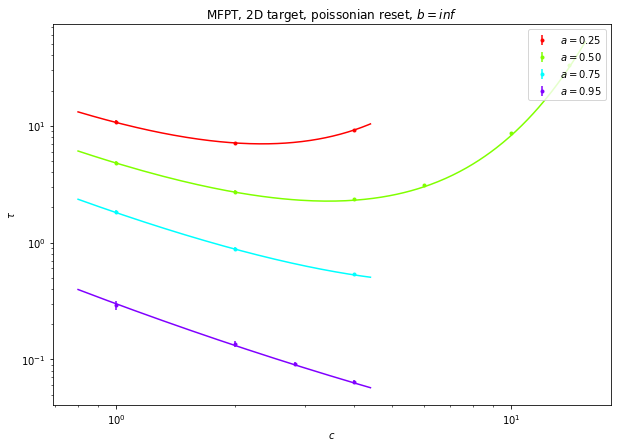

In [52]:
groups_b = Res.groupby( Res['b'].apply(lambda x: round(x,2)) )
for b, Res_b in list(groups_b):

    if len(Res_b) < 5:
        continue
    groups, group_pts_min, colors = do_grouping(Res_b, by='a', n_colors_max=11)
    
    plt.figure(figsize=(10,7))
    for a, Res_a in list(groups):

        if len(Res_a) > group_pts_min:
            c = np.linspace(0.8, 1.1*np.max(Res_a['c']), 200)
            plt.plot(c, fpt_2d_poisson_tau(b,c,a), color=colors[a])
            plt.errorbar(Res_a['c'], Res_a['tau'], label=r"$a={:.2f}$".format(a), color=colors[a], yerr=Res_a['tau_err'], fmt='.')
            
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r"$c$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.title(r"MFPT, 2D target, poissonian reset, $b={}$".format(b))
    plt.savefig("mfpt-2d-poisson-b_{}.pdf".format(b), bbox_inches='tight')
    plt.show()

# Analyse pour cible 2D et reset périodique, $b=\infty$

In [34]:
tau_th_cache = {}

In [35]:
%matplotlib nbagg

In [36]:
%matplotlib inline

In [37]:
Res = pd.DataFrame()
load_folder("data-2d-periodical-fix")
reset_type = 'per'

62


In [38]:
groups, group_pts_min, colors = do_grouping(Res, by='a', n_colors_max=8)

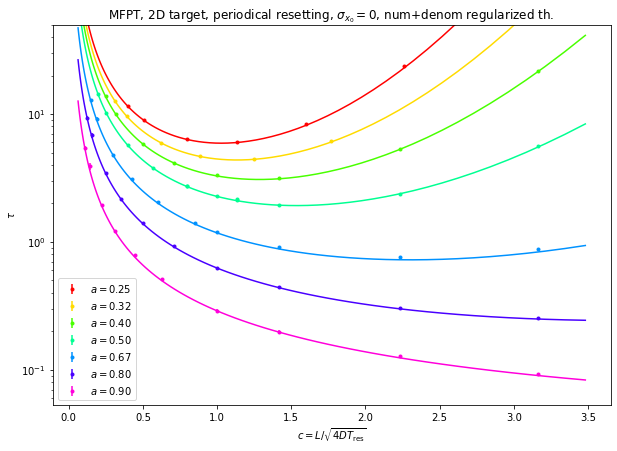

In [39]:
plt.figure(figsize=(10,7))
for a, Res_a in list(groups):
    
    if len(Res_a) > group_pts_min:
        c = np.logspace(-4, 1.8, 100, base=2)
        name = '2d-per-binf-a'+str(a)
        if not (name in tau_th_cache):
            tau_th_cache[name] = fpt_2d_periodical_tau(np.inf,c,a)
        plt.plot(c, tau_th_cache[name], color=colors[a])
        c, tau, err = order_c_tau(Res_a)
        plt.errorbar(c, tau, label=r"$a={:.2f}$".format(a), color=colors[a], yerr=err, fmt='.')

logscale = True
if logscale:
    plt.yscale('log')
plt.ylim((None,50))
show_labels()
plt.title("MFPT, 2D target, periodical resetting, $\sigma_{x_0}=0$, num+denom regularized th.")
plt.savefig("mfpt-2d-periodical-b_inf"+("-log" if logscale else "")+".pdf", bbox_inches='tight')

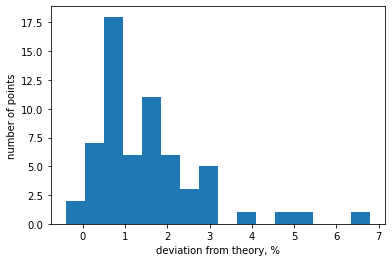

In [40]:
Res['tau_th'] = fpt_2d_periodical_tau(np.inf,Res['c'],Res['a'])
Res['tau_dev%'] = ((Res['tau']-Res['tau_th'])/Res['tau_th'] * 100).apply(lambda x: round(x,1))
plt.hist(Res['tau_dev%'], bins=16)
plt.xlabel(r"deviation from theory, %")
plt.ylabel("number of points")
plt.savefig("mfpt-2d-periodical-devhist.pdf", bbox_inches='tight')

# Analyse pour cible 2D et reset périodique, $b$ variable

In [11]:
Res = pd.DataFrame()
reset_type = 'periodical'
load_folder("data-2d-periodical-x0var")
Res['a'] = Res['a'].apply(lambda x: round(x,2))
Res['b'] = Res['b'].apply(lambda x: round(x,4))
Res['c'] = Res['c'].apply(lambda x: round(x,4))

159


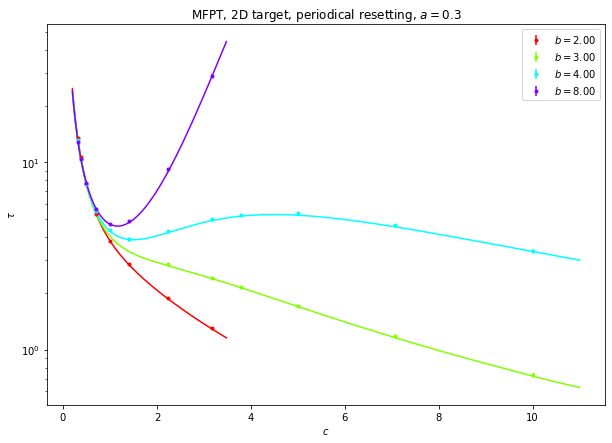

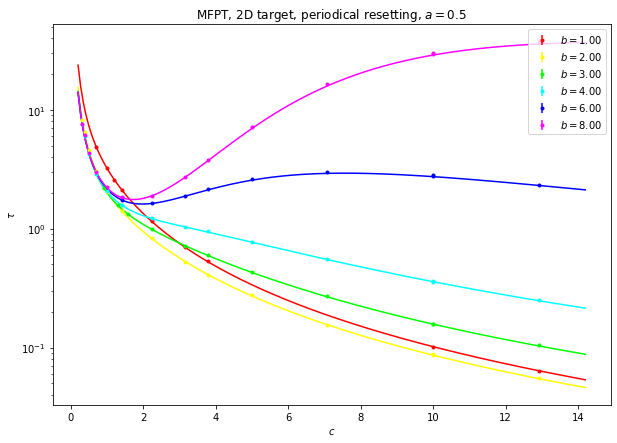

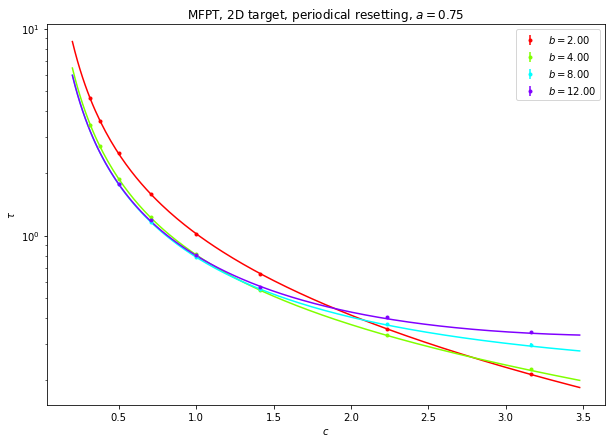

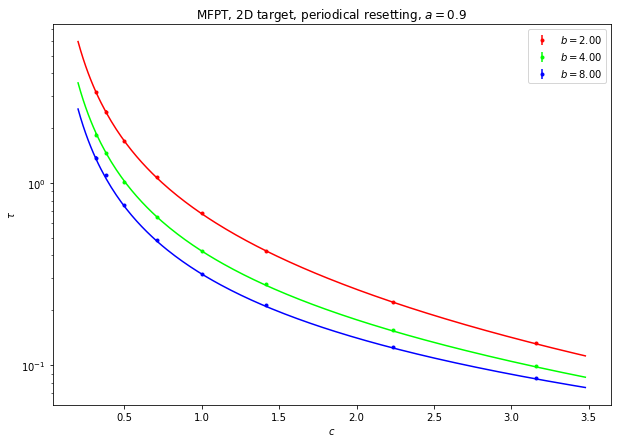

In [12]:
groups_a = Res.groupby( Res['a'].apply(lambda x: round(x,2)) )
for a, Res_a in list(groups_a):
    
    if len(Res_a) < 5:
        continue
    groups, group_pts_min, colors = do_grouping(Res_a, by='b', n_colors_max=11)
    
    plt.figure(figsize=(10,7))
    for b, Res_b in list(groups):

        if len(Res_b) > group_pts_min:
            c = np.linspace(0.2, 1.1*np.max(Res_b['c']), 200)
            plt.plot(c, fpt_2d_periodical_tau(b,c,a,use_cache="th-cache-2d-periodical/"), color=colors[b])
            plt.errorbar(Res_b['c'], Res_b['tau'], label=r"$b={:.2f}$".format(b), color=colors[b], yerr=Res_b['tau_err'], fmt='.')
            
    plt.yscale('log')
    plt.xlabel(r"$c$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.title(r"MFPT, 2D target, periodical resetting, $a={}$".format(a))
    plt.savefig("mfpt-2d-periodical-a_{}.pdf".format(a), bbox_inches='tight')

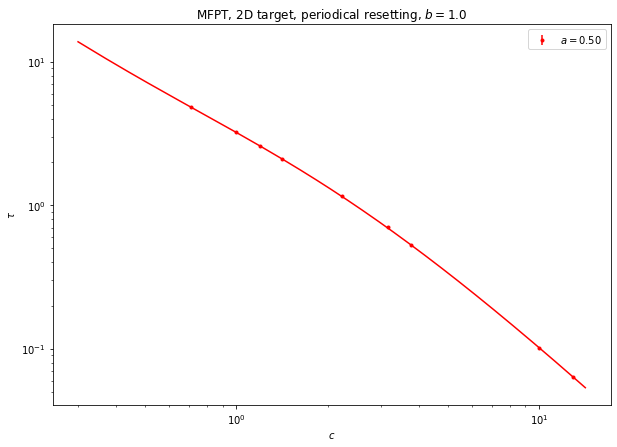

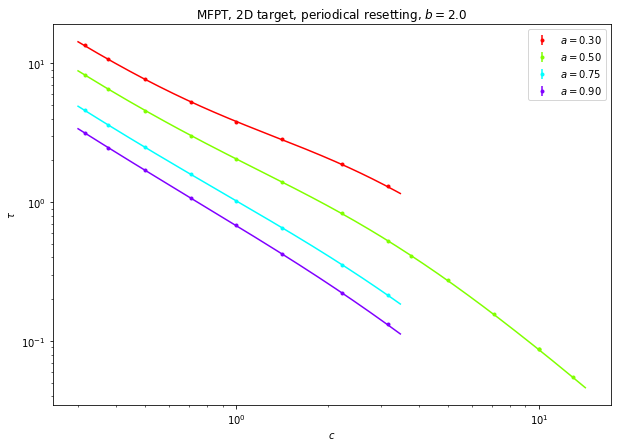

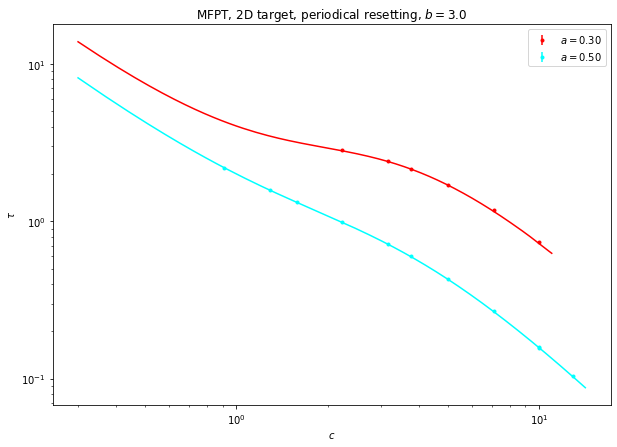

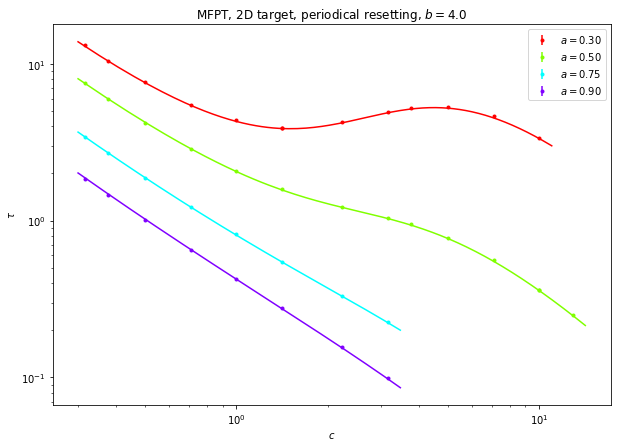

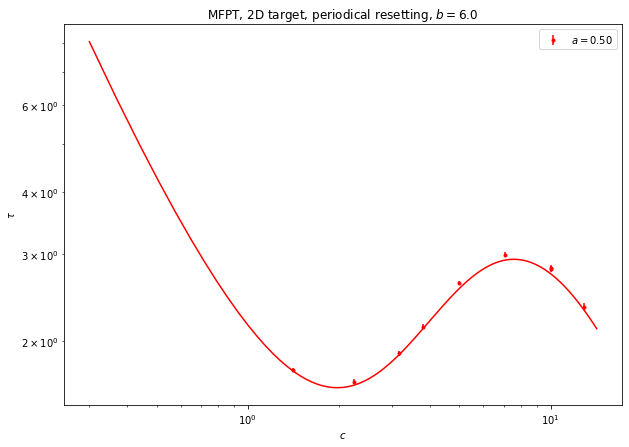

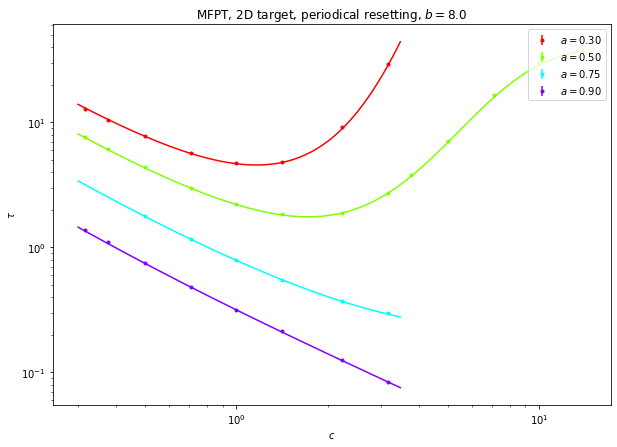

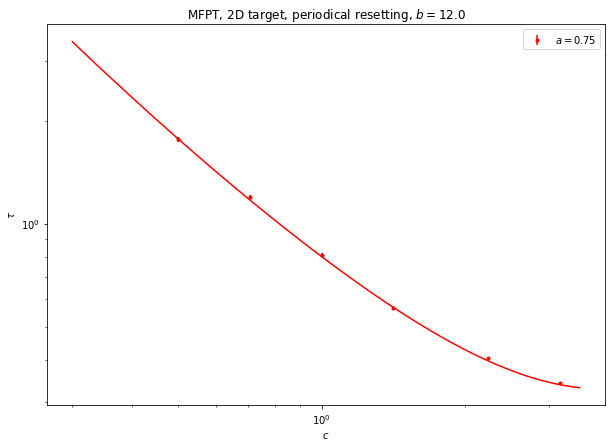

In [13]:
groups_b = Res.groupby( Res['b'].apply(lambda x: round(x,2)) )
for b, Res_b in list(groups_b):

    if len(Res_b) < 5:
        continue
    groups, group_pts_min, colors = do_grouping(Res_b, by='a', n_colors_max=11)
    
    plt.figure(figsize=(10,7))
    for a, Res_a in list(groups):

        if len(Res_a) > group_pts_min:
            c = np.linspace(0.3, 1.1*np.max(Res_a['c']), 200)
            plt.plot(c, fpt_2d_periodical_tau(b,c,a,use_cache="th-cache-2d-periodical/"), color=colors[a])
            plt.errorbar(Res_a['c'], Res_a['tau'], label=r"$a={:.2f}$".format(a), color=colors[a], yerr=Res_a['tau_err'], fmt='.')
            
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r"$c$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.title(r"MFPT, 2D target, periodical resetting, $b={}$".format(b))
    plt.savefig("mfpt-2d-periodical-b_{}.pdf".format(b), bbox_inches='tight')
    plt.show()

In [16]:
Res['tau_th'] = fpt_2d_periodical_tau(Res['b'],Res['c'],Res['a'])
Res['tau_dev%'] = ((Res['tau']-Res['tau_th'])/Res['tau_th'] * 100).apply(lambda x: round(x,1))
Res.sort_values(by='tau_dev%', ascending=False).head(10)

/usr/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,D,part_m,x0sigma,L,b,c,mfpt,fpt_stdev,n_traj,Delta_t,Rtol,a,reset_period,i,tau,tau_err,tau_th,tau_dev%
90,1.0,0.0,0.025000,0.2,8.0,7.0711,0.165228,0.164565,15005.0,1.000000e-07,0.10,0.5,0.00020,113,16.522754,0.268689,15.803260,4.6
156,1.0,0.0,0.025000,0.2,8.0,12.9099,0.368965,0.362373,20002.0,1.000000e-07,0.10,0.5,0.00006,235,36.896489,0.512448,35.701366,3.3
70,1.0,0.0,0.025000,0.2,8.0,2.2361,0.091986,0.091861,16201.0,1.000000e-07,0.06,0.3,0.00200,87,9.198572,0.144341,8.909884,3.2
150,1.0,0.0,0.025000,0.2,8.0,10.0000,0.297339,0.298423,20006.0,1.000000e-07,0.10,0.5,0.00010,225,29.733890,0.421971,28.812534,3.2
91,1.0,0.0,0.025000,0.2,8.0,10.0000,0.296818,0.296316,15006.0,1.000000e-07,0.10,0.5,0.00010,114,29.681840,0.483786,28.812534,3.0
81,1.0,0.0,0.025000,0.2,8.0,0.3780,0.010986,0.026091,50084.0,1.000000e-07,0.18,0.9,0.07000,102,1.098568,0.023317,1.067509,2.9
106,1.0,0.0,0.033333,0.2,6.0,10.0000,0.028116,0.028156,30015.0,1.000000e-07,0.10,0.5,0.00010,147,2.811557,0.032504,2.736977,2.7
105,1.0,0.0,0.033333,0.2,6.0,7.0711,0.029913,0.029750,30025.0,1.000000e-07,0.10,0.5,0.00020,146,2.991259,0.034339,2.915678,2.6
104,1.0,0.0,0.033333,0.2,6.0,5.0000,0.026213,0.026214,30015.0,1.000000e-07,0.10,0.5,0.00040,145,2.621269,0.030261,2.556691,2.5
116,1.0,0.0,0.050000,0.2,4.0,7.0711,0.046379,0.046655,20012.0,1.000000e-07,0.06,0.3,0.00020,164,4.637915,0.065960,4.524173,2.5


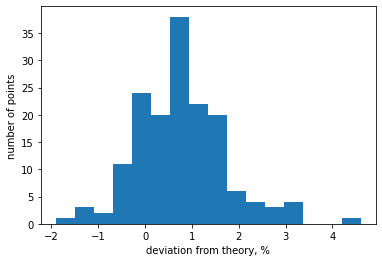

In [17]:
plt.hist(Res['tau_dev%'], bins=16)
plt.xlabel(r"deviation from theory, %")
plt.ylabel("number of points")
plt.savefig("mfpt-2d-periodical-devhist.pdf", bbox_inches='tight')

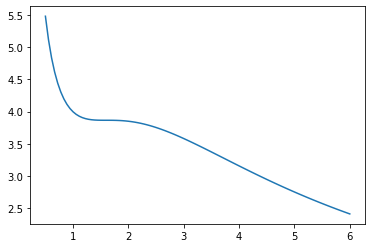

In [118]:
c = np.linspace(0.5,6,100)
y = fpt_periodic_tau(2.3977617525,c)
plt.plot(c, y)